In [3]:
def readCSV(filepath, extrapolate_year, threshold_year):
    month_mapping = {
        "04": "January",
        "13": "February",
        "21": "March",
        "29": "April",
        "38": "May",
        "46": "June",
        "54": "July",
        "63": "August",
        "71": "September",
        "79": "October",
        "88": "November",
        "96": "December"
    }

    bulk_year_data = {}
    extrapolate_year_data = {}
    threshold_year_data = {}
    month_max_year = {}  # Variable to store the year for each month's maximum value
    prev_max_value = {}
    
    with open(filepath, "r") as file:
        next(file)  # Skip the first row
        next(file)  # Skip the second row
        for line in file:
            data = line.strip().split(",")
            year_month = data[0]
            year = int(year_month.split(".")[0])
            month_decimal = year_month.split(".")[1]
            month_name = month_mapping[month_decimal]
            temp_anomaly = float(data[2])

            # Check if the current value is greater than the previous maximum for the corresponding month
            if month_name not in prev_max_value or temp_anomaly > prev_max_value[month_name]:
                prev_max_value[month_name] = temp_anomaly
                month_max_year[month_name] = year
            
            if year == extrapolate_year:
                if month_name in extrapolate_year_data:
                    extrapolate_year_data[month_name].append(temp_anomaly)
                else:
                    extrapolate_year_data[month_name] = [temp_anomaly]
            elif year == threshold_year:
                if month_name in threshold_year_data:
                    threshold_year_data[month_name].append(temp_anomaly)
                else:
                    threshold_year_data[month_name] = [temp_anomaly]
            else:
                if month_name in bulk_year_data:
                    bulk_year_data[month_name].append(temp_anomaly)
                else:
                    bulk_year_data[month_name] = [temp_anomaly]


    # Print the maximum value for each year
    for month_name, year in month_max_year.items():
        max_value = prev_max_value[month_name]
        print(f"Maximum value for {month_name} reached in {year}: {max_value} C")
    return bulk_year_data, extrapolate_year_data, threshold_year_data


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold, extrapolate_month):
    fig, ax = plt.subplots(figsize=(8, 12))

    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []

    for month_name, temp_anomalies in bulk_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['All Other Years'] * len(temp_anomalies))

    for month_name, temp_anomalies in threshold_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Threshold Year'] * len(temp_anomalies))

    for month_name, temp_anomalies in extrapolate_year_data.items():
        data.extend(temp_anomalies)
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Extrapolate Year'] * len(temp_anomalies))

    # Set the style of the strip plot
    sns.stripplot(x=labels, y=data, hue=hue, dodge=True, alpha=0.9, palette=['#1f77b4', '#ff7f0e', '#ffdf00'], linewidth=0)

    # Add a horizontal line at the rise threshold
    ax.axhline(y=rise_threshold, color='g', linestyle='--')

    # Set the y-axis label
    ax.set_ylabel('Temperature Anomaly (C)')

    # Move the legend to the right of the chart
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set more subticks on the y-axis
    plt.yticks(np.arange(-1.0, 1.6, 0.1))

    # Increase spacing between each month
    plt.subplots_adjust(wspace=0.6)
        
    # Add a title to the chart
    plt.title('Global Monthly Temperature Anomalies' + '\n' + 
              'Land + Ocean Temperature' + '\n' +
              'Relative to monthly averages of 1951-1980' + '\n' +
              'Extrapolating from ' + extrapolate_month + ' by:' '\n' +
              'Adding sorted max difference for month to anomaly record'
             )

    
    # Show the plot
    plt.show()


In [15]:
import copy

def extrapolate_from_historical_months_max_spread(bulk_year_data, threshold_year_data, extrapolate_year_data):
    # Combine all datasets into all_year_data
    all_year_data = copy.deepcopy(bulk_year_data)

    # Append threshold_year_data to all_year_data
    for month, temp_anomalies in threshold_year_data.items():
        all_year_data[month].extend(temp_anomalies)

    # Append extrapolate_year_data to all_year_data
    for month, temp_anomalies in extrapolate_year_data.items():
        all_year_data[month].extend(temp_anomalies)

    # Sort the data for each month in all_year_data
    for month, temp_anomalies in all_year_data.items():
        all_year_data[month] = sorted(temp_anomalies)

    # Calculate the maximum difference between successive values for each month
    max_difference = {}
    for month, temp_anomalies in all_year_data.items():
        differences = [j - i for i, j in zip(temp_anomalies[:-1], temp_anomalies[1:])]
        max_difference[month] = max(differences)

    # Fill in extrapolate_year_data based on max_difference and all_year_data
    missing_months = set(all_year_data.keys()) - set(extrapolate_year_data.keys())
    
    for month in missing_months:
        max_temp = max(all_year_data[month])
        extrapolate_year_data[month] = [max_temp + max_difference[month]]

    return [extrapolate_year_data, next(iter(missing_months))]


In [16]:
def graph_temps(filepath, extrapolate_year, threshold_year, rise_threshold):
    bulk_year_data, extrapolate_year_data, threshold_year_data = readCSV(filepath, extrapolate_year, threshold_year)
    
    [extrapolate_year_data, extrapolate_month] = extrapolate_from_historical_months_max_spread(
        bulk_year_data, threshold_year_data, extrapolate_year_data
    )
    
    graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold, extrapolate_month)

In [17]:
#### CONFIG FOR MAIN PARAMETERS
# current year of missing months
extrapolate_year = 2023
# file path to CSV for Monthly Mean Global Surface Temperature
# from https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv
#   renamed from graph.csv to global_temp_monthly_mean.csv
filepath = 'global_temp_monthly_mean.csv'
# threshold for new record monthly land+ocean temp anomaly (must exceed this value to be new anomaly record)
rise_threshold = 1.37
# year in which record was broken (year of the rise_threshold)
threshold_year = 2016

Maximum value for January reached in 2016: 1.17 C
Maximum value for February reached in 2016: 1.37 C
Maximum value for March reached in 2016: 1.36 C
Maximum value for April reached in 2020: 1.13 C
Maximum value for May reached in 2020: 1.01 C
Maximum value for June reached in 2023: 1.08 C
Maximum value for July reached in 2023: 1.18 C
Maximum value for August reached in 2016: 1.02 C
Maximum value for September reached in 2020: 0.99 C
Maximum value for October reached in 2015: 1.09 C
Maximum value for November reached in 2020: 1.1 C
Maximum value for December reached in 2015: 1.16 C


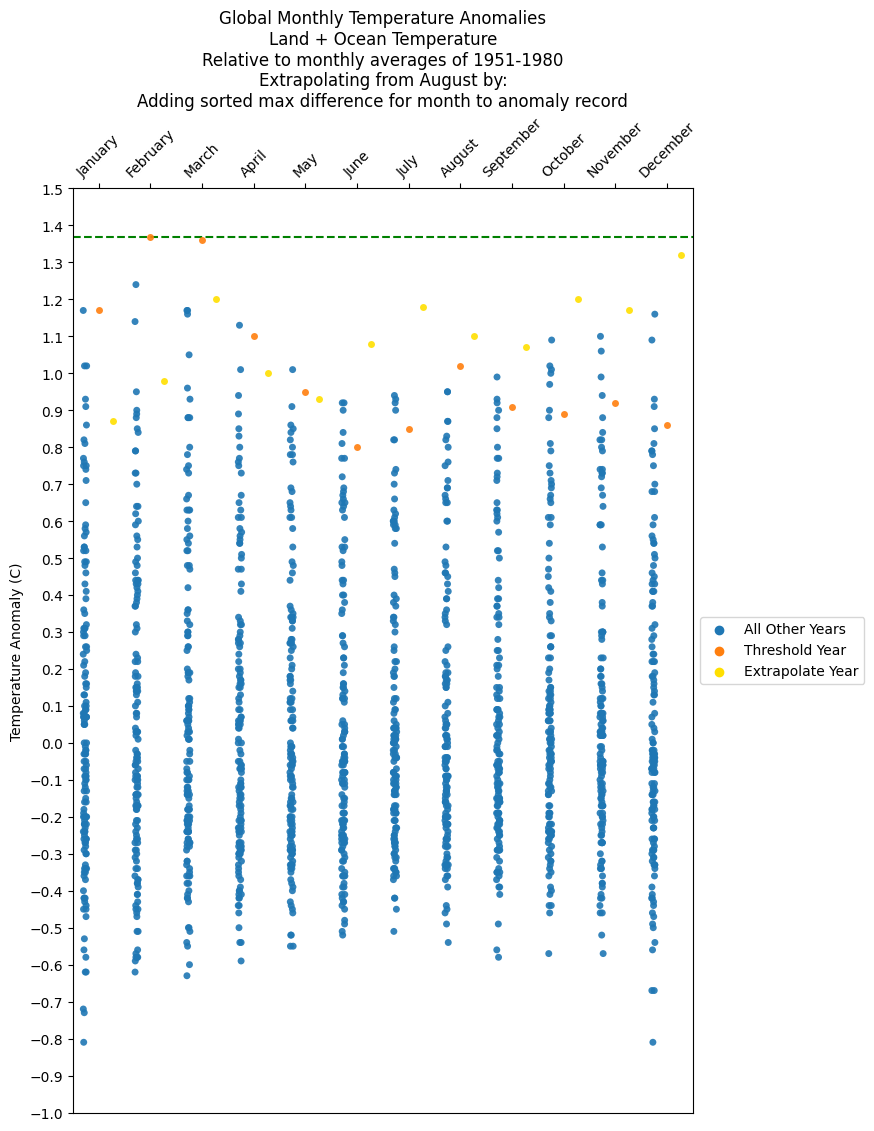

In [18]:
graph_temps(filepath, extrapolate_year, threshold_year, rise_threshold)